In [1]:
import torch
from torch import nn as nn
import math
from glob import glob
from torchsummary import summary
from torch_snippets import *
from torch_snippets.torch_loader import Report
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image 

#is GPU available?
gpu = torch.cuda.is_available()

#defining device where to to the computation
device = torch.device(0) if gpu else torch.device('cpu')

### Randomly split a fileset into training, validation, and test sets: output lists of image names

In [2]:
# Set the folder with the samples (images) that compose a dataset and the number of classes

orig_dir   = './images/corel'
nclasses   = 6

# Set the desired image size for rescaling and maximum value for normalization

width       = 224 
height      = 224
nchannels   = 3
maxval      = 255. 
input_shape = (nchannels,height,width)

# Set the percentages of samples that will be used for training, validation and test. 

train_perc = 0.40
valid_perc = 0.30
test_perc  = 0.30

# Create training, validation, and test sets.

data = glob(orig_dir+"/*.png") # it returns a list of image filenames

num_train_samples = int(len(data)*train_perc)
num_valid_samples = int(len(data)*valid_perc)  
num_test_samples  = len(data) - num_train_samples - num_valid_samples 
np.random.shuffle(data) # randomly change the order of the filenames in data
trainset = data[:num_train_samples] 
validset = data[num_train_samples:num_train_samples+num_valid_samples]
testset  = data[num_train_samples+num_valid_samples:]

# Set output model name

model_name  = 'CorelCNN.pth'

### Create image datasets with some preprocessing: output a list of image tensors

In [3]:
# Regular preprocessing transformation. The input is a PIL image, which after being resized, 
# it is converted into a tensor for normalization using the ImageNet mean and stdev parameters. 

prep = transforms.Compose([
    transforms.Resize((224,224), interpolation=transforms.InterpolationMode.BILINEAR, 
                      max_size=None, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))   
])

# Such transformations are applied everytime images are loaded from the filename lists in training, validation, 
# and test sets. We will do that during training, then by adding affine transformations and increasing the number 
# of epochs, we are actually implementing data augmentation. 

aug = transforms.Compose([
    transforms.Resize((300,300), interpolation=transforms.InterpolationMode.BILINEAR, 
                      max_size=None, antialias=True),
    transforms.RandomAffine(degrees=10, translate=(0.05,0.10), scale=(0.9,1.1), shear=(-2,2),
                            interpolation=transforms.InterpolationMode.BILINEAR, 
                            fill=0),
    transforms.CenterCrop(250),
    transforms.Resize((224,224), interpolation=transforms.InterpolationMode.BILINEAR, 
                      max_size=None, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))   
])

# Create an image dataset by applying one of the preprocessing transformations above

class ImageDataset(): # there are three mandatory functions: init, len, getitem
    def __init__(self, dataset, transform=None):
        # it gets the image true labels and set the preprocessing transformation
        self.dataset   = dataset
        self.targets   = [int(str(x).split("/")[-1].split("_")[0])-1 for x in self.dataset]
        self.transform = transform
    def __len__(self): return len(self.dataset)        
    def __getitem__(self, ix): # returns the item at position ix 
        filename = self.dataset[ix]
        target   = self.targets[ix]
        image    = Image.open(filename) # It is a PIL image
        if (self.transform is not None):
            image = self.transform(image)
        else: # just reshape the image as a tensor with nchannels, height, width
            image = torch.from_numpy(np.array(image)).permute(2,0,1).float()                  
        return(image,target) 

In [4]:
trainset = ImageDataset(trainset, aug) # verify the difference with and wothout data augmentation
validset = ImageDataset(validset, prep)
testset  = ImageDataset(testset, prep)

### Visualize selected images

Number of images: 142
Images are 224x224x3
Class of the image:  5


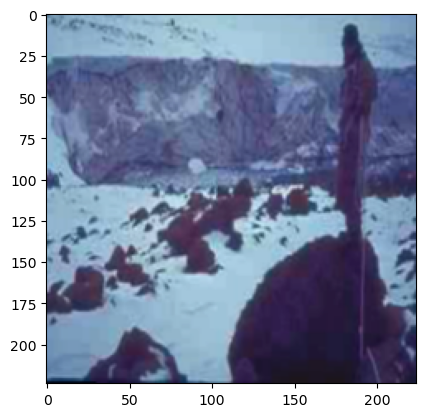

In [5]:
# visualize images from the trainset

print("Number of images:", len(trainset))
image, target = trainset[100] # it executes getitem
image     = image.permute(1,2,0).numpy()
image     = 255*(image - np.min(image))/(np.max(image)-np.min(image))
image     = image.astype('uint8')
print("Images are {}x{}x{}".format(width,height,nchannels))
plt.imshow(image)
print("Class of the image: ", target+1)
plt.show()

### Generate batches with batchsize images at random

In [6]:
batchsize = 32
trainload = DataLoader(trainset, batch_size=batchsize, shuffle=True)
testload  = DataLoader(testset, batch_size=batchsize, shuffle=True)
validload = DataLoader(validset, batch_size=batchsize, shuffle=True)

next(iter(trainload)) # inspect next item in the trainload

[tensor([[[[-1.8610, -1.8953, -1.8610,  ..., -0.3541, -0.5253, -0.8678],
           [-1.8268, -1.8610, -1.8439,  ..., -0.4226, -0.6281, -1.0048],
           [-1.8097, -1.8439, -1.8610,  ..., -0.4739, -0.7308, -1.0733],
           ...,
           [ 0.5878,  0.5022,  0.2624,  ..., -1.8610, -1.6727, -1.3987],
           [ 0.6563,  0.5536,  0.1939,  ..., -1.7754, -1.5357, -1.1760],
           [ 0.6049,  0.4508,  0.0741,  ..., -1.7583, -1.5528, -1.3473]],
 
          [[-1.5455, -1.4930, -1.4580,  ..., -0.3200, -0.5476, -0.9328],
           [-1.5455, -1.5280, -1.5105,  ..., -0.3901, -0.6702, -1.0728],
           [-1.5630, -1.5805, -1.5630,  ..., -0.4601, -0.7752, -1.1604],
           ...,
           [-0.0224, -0.0399, -0.1099,  ..., -1.7031, -1.5105, -1.2129],
           [ 0.0826,  0.0301, -0.1099,  ..., -1.6331, -1.3880, -1.0203],
           [ 0.0476, -0.0399, -0.1800,  ..., -1.6331, -1.4230, -1.2129]],
 
          [[-1.4384, -1.4036, -1.3861,  ..., -1.1421, -1.3339, -1.6476],
           [-

### ConvNet model

In [7]:
# a convolutional block
def conv_block(nchannels_in, nchannels_out, stride_val):
    return nn.Sequential(
        #defining convolutional layer 
        nn.Conv2d(in_channels=nchannels_in, out_channels=nchannels_out, kernel_size=(5, 5),
                  stride=1, padding=2, bias=False),
        #defining a batch normalization layer, which dismisses the need for bias in the previous conv layer
        nn.BatchNorm2d(num_features=nchannels_out),
        #defining activation layer
        nn.ReLU(),
        #defining a pooling layer
        nn.MaxPool2d(kernel_size=(3, 3), stride=stride_val, padding=1)
    )

class CorelNet(nn.Module):

    def __init__(self, input_shape, num_classes):
        super(CorelNet, self).__init__()
        
        #defining feature extractor
        self.features = nn.Sequential(
            conv_block(input_shape[0],32,2),
            conv_block(32,256,2)          
        )

        #defining classifier
        self.classifier = nn.Sequential(
            nn.Linear(in_features=input_shape[1]//4*input_shape[2]//4*256, out_features=64, bias=True),
            #nn.Dropout(0.20),
            nn.ReLU(),
            nn.Linear(64, nclasses)
        )

        #initialize weights
        self._initialize_weights()

    def forward(self, x):
       #extracts features
        x = self.features(x)

        #transforms outputs into a 2D tensor
        x = torch.flatten(x, start_dim=1)

        #classifies features
        y = self.classifier(x)
  
        return y
  
    def _initialize_weights(self):
        #for each submodule of our network
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                #get the number of elements in the layer weights
                n = m.kernel_size[0] * m.kernel_size[1] * m.in_channels    
                #initialize layer weights with random values generated from a normal
                #distribution with mean = 0 and std = sqrt(2. / n))
                m.weight.data.normal_(mean=0, std=math.sqrt(2. / n))

                if m.bias is not None:
                    #initialize bias with 0 
                    m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                #initialize layer weights with random values generated from a normal
                #distribution with mean = 0 and std = 1/100
                m.weight.data.normal_(mean=0, std=0.01)
                if m.bias is not None:
                #initialize bias with 0 
                    m.bias.data.zero_()

### Create the model

In [8]:
model = CorelNet(input_shape, nclasses).to(device)
summary(model,input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]           2,400
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
         MaxPool2d-4         [-1, 32, 112, 112]               0
            Conv2d-5        [-1, 256, 112, 112]         204,800
       BatchNorm2d-6        [-1, 256, 112, 112]             512
              ReLU-7        [-1, 256, 112, 112]               0
         MaxPool2d-8          [-1, 256, 56, 56]               0
            Linear-9                   [-1, 64]      51,380,288
             ReLU-10                   [-1, 64]               0
           Linear-11                    [-1, 6]             390
Total params: 51,588,454
Trainable params: 51,588,454
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Fo

### Define the loss function with L2 regularization

In [9]:
def Criterion(model, preds, targets):
    ce            = nn.CrossEntropyLoss().to(device)
    loss          = ce(preds, targets.long()) 
    # add l2_regularization            
    l2_regularization = 0
    for param in model.parameters():
        l2_regularization += torch.norm(param,2)
    loss += 0.0001*l2_regularization # 0.0001 is the weight_decay
    # compute mean accuracy in the batch
    pred_labels   = torch.max(preds, 1)[1] # same as argmax
    acc           = torch.sum(pred_labels == targets.data)
    n             = pred_labels.size(0)
    acc           = acc/n
    return loss, acc


criterion = Criterion

### Define optimizer and learning scheduler

In [10]:
optimizer    = optim.Adam(model.parameters(), lr=1e-5)
# gamma=0.9 is a multiplicative factor for lr decay at every epoch
# lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.9)
# gamma=0.9 is a multiplicative factor for lr decay at every step_size=number of epochs
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.9)

### Clean up memory if needed

In [11]:
import gc
#del trainset, validset, testset
gc.collect()
torch.cuda.empty_cache()

### Define training and validation functions

In [12]:
def train_batch(model, data, optimizer, criterion, device):
    model.train()
    ims, targets = data
    ims     = ims.to(device=device)
    targets = targets.to(device=device)
    preds   = model(ims)
    loss, acc = criterion(model, preds, targets)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion, device):
    model.eval()
    ims, targets = data
    ims     = ims.to(device=device)
    targets = targets.to(device=device)
    preds   = model(ims)
    loss, acc = criterion(model, preds, targets)
    return loss.item(), acc.item()

### Train the model and report the results

In [13]:
# initializing variables
n_epochs = 100
log      = Report(n_epochs)

# starting training and validation
for ex in range(n_epochs):
    N = len(trainload)
    for bx, data in enumerate(trainload):
        loss, acc = train_batch(model, data, optimizer, criterion, device)
        #report results for the batch
        log.record((ex+(bx+1)/N), trn_loss=loss, trn_acc=acc, end='\r')

    N = len(validload)
    for bx, data in enumerate(validload):
        loss, acc = validate_batch(model, data, criterion, device)
        log.record((ex+(bx+1)/N), val_loss=loss, val_acc=acc, end='\r')

    if (ex+1)%10==0: log.report_avgs(ex+1)
    #count epochs for auto-adjusting the learning rate
    lr_scheduler.step()

EPOCH: 10.000  trn_acc: 0.963  trn_loss: 0.213  val_acc: 0.883  val_loss: 0.304  (27.52s - 247.69s remaining)
EPOCH: 20.000  trn_acc: 0.979  trn_loss: 0.156  val_acc: 0.872  val_loss: 0.298  (49.46s - 197.86s remaining)
EPOCH: 30.000  trn_acc: 1.000  trn_loss: 0.110  val_acc: 0.938  val_loss: 0.241  (72.02s - 168.06s remaining)
EPOCH: 40.000  trn_acc: 1.000  trn_loss: 0.068  val_acc: 0.945  val_loss: 0.211  (93.40s - 140.10s remaining)
EPOCH: 50.000  trn_acc: 1.000  trn_loss: 0.075  val_acc: 0.953  val_loss: 0.175  (114.88s - 114.88s remaining)
EPOCH: 60.000  trn_acc: 1.000  trn_loss: 0.031  val_acc: 0.897  val_loss: 0.344  (136.37s - 90.91s remaining)
EPOCH: 70.000  trn_acc: 0.986  trn_loss: 0.057  val_acc: 0.945  val_loss: 0.176  (158.10s - 67.76s remaining)
EPOCH: 80.000  trn_acc: 1.000  trn_loss: 0.038  val_acc: 0.936  val_loss: 0.357  (179.66s - 44.92s remaining)
EPOCH: 90.000  trn_acc: 1.000  trn_loss: 0.026  val_acc: 0.961  val_loss: 0.221  (201.16s - 22.35s remaining)
EPOCH: 10

### Plot the results

100%|███████████████████████████████████████| 201/201 [00:00<00:00, 1369.18it/s]


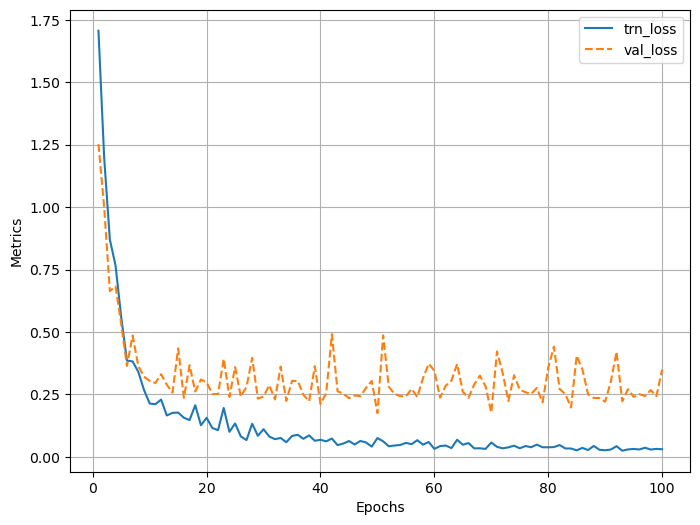

100%|██████████████████████████████████████| 201/201 [00:00<00:00, 12799.35it/s]


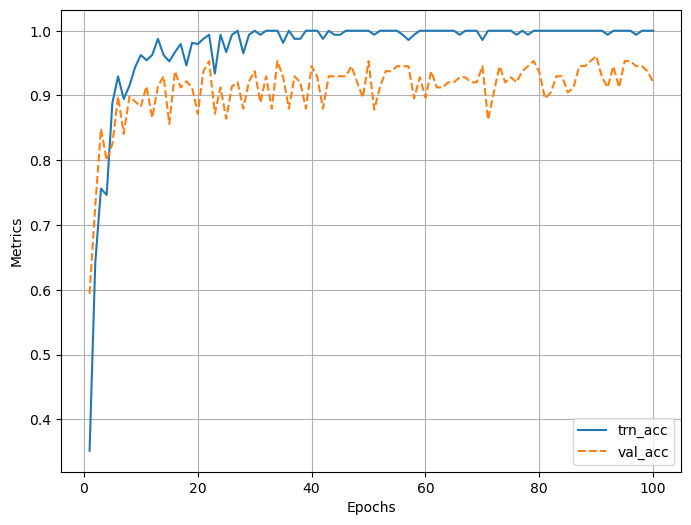

In [14]:
log.plot_epochs(['trn_loss','val_loss'])
log.plot_epochs(['trn_acc','val_acc'])

### Evaluate the model

In [15]:
def Test(model, testload, criterion, device):
    N = len(testload)
    mean_loss = 0
    mean_acc  = 0
    for bx, data in enumerate(testload):
        loss, acc  = validate_batch(model, data, criterion, device)
        mean_loss += loss
        mean_acc  += acc
    
    mean_loss = mean_loss / N
    mean_acc  = mean_acc / N
    return(mean_loss, mean_acc)

(loss, acc) = Test(model, testload, criterion, device)
print('Loss: {:.6f} Acc: {:.6f}'.format(loss,acc))

Loss: 0.149515 Acc: 0.953835


### Save the model

In [16]:
#torch.save(model.to('cpu').state_dict(), model_name)

#### Exercise: Play with optimizers, network architecture and hyperparameters to improve results without underfitting and overfitting. Note that you are using data augmentation, which might requires more epochs and lower learning rates for convergence. Verify preprocessing with no data augmentation and less training samples with data augmentation. 

### Visualize activations at the output of the last convolutional block for a given image

In [17]:
image, target = trainset[100]
image.size()

torch.Size([3, 224, 224])

In [18]:
image   = image.unsqueeze(0).to(device) 

In [19]:
def get_corelnet_feature_map(model, input_tensor: torch.Tensor) -> torch.Tensor:
    """
    Simple method: Extract feature map by calling model.features directly
    
    Args:
        model: CorelNet model instance  
        input_tensor: Input tensor
    image, target = trainset[100] # it executes getitem
image     = image.permute(1,2,0).numpy()
image     = 255*(image - np.min(image))/(np.max(image)-np.min(image))
image     = image.astype('uint8')
print("Images are {}x{}x{}".format(width,height,nchannels))
plt.imshow(image)
    Returns:
        Feature map from the feature extractor (before flattening)
    """
    model.eval()
    with torch.no_grad():
        feature_map = model.features(input_tensor)
    return feature_map

In [20]:
def visualize_corelnet_features(feature_map: torch.Tensor, 
                               max_channels: int = 16,
                               start_channel: int = 0,
                               figsize: tuple = (15, 10),
                               sample_idx: int = 0):
    """
    Visualize CorelNet feature maps
    
    Args:
        feature_map: Feature map tensor (batch_size, channels, height, width)
        max_channels: Maximum number of channels to display
        start_channel: Starting channel index (0-based)
        figsize: Figure size for matplotlib
        sample_idx: Which sample from the batch to visualize
    """
    if feature_map.dim() == 4:
        feature_map_sample = feature_map[sample_idx]  # Shape: (channels, height, width)
    else:
        feature_map_sample = feature_map
    
    total_channels = feature_map_sample.shape[0]
    end_channel = min(start_channel + max_channels, total_channels)
    num_channels = end_channel - start_channel
    
    if start_channel >= total_channels:
        raise ValueError(f"start_channel ({start_channel}) must be less than total channels ({total_channels})")
    
    print(f"Feature map shape: {feature_map.shape}")
    print(f"Total channels: {total_channels}")
    print(f"Visualizing channels {start_channel}-{end_channel-1} from sample {sample_idx}")
    
    
    # Calculate grid dimensions
    cols = 4
    rows = (num_channels + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    for i in range(num_channels):
        ax = axes[i]
        channel_idx = start_channel + i
        channel_data = feature_map_sample[channel_idx].cpu().numpy()
        
        im = ax.imshow(channel_data, cmap='viridis')
        ax.set_title(f'Channel {channel_idx}\nMin: {channel_data.min():.2f}\nMax: {channel_data.max():.2f}', 
                    fontsize=10)
        ax.axis('off')
        plt.colorbar(im, ax=ax, shrink=0.6)
    
    # Hide unused subplots
    for i in range(num_channels, len(axes)):
        axes[i].axis('off')
    
    plt.suptitle(f'CorelNet Feature Maps - Channels {start_channel}-{end_channel-1}\nShape: {feature_map.shape}', 
                 fontsize=14)
    plt.tight_layout()
    plt.show()

Feature map shape: torch.Size([1, 256, 56, 56])
Total channels: 256
Visualizing channels 32-47 from sample 0


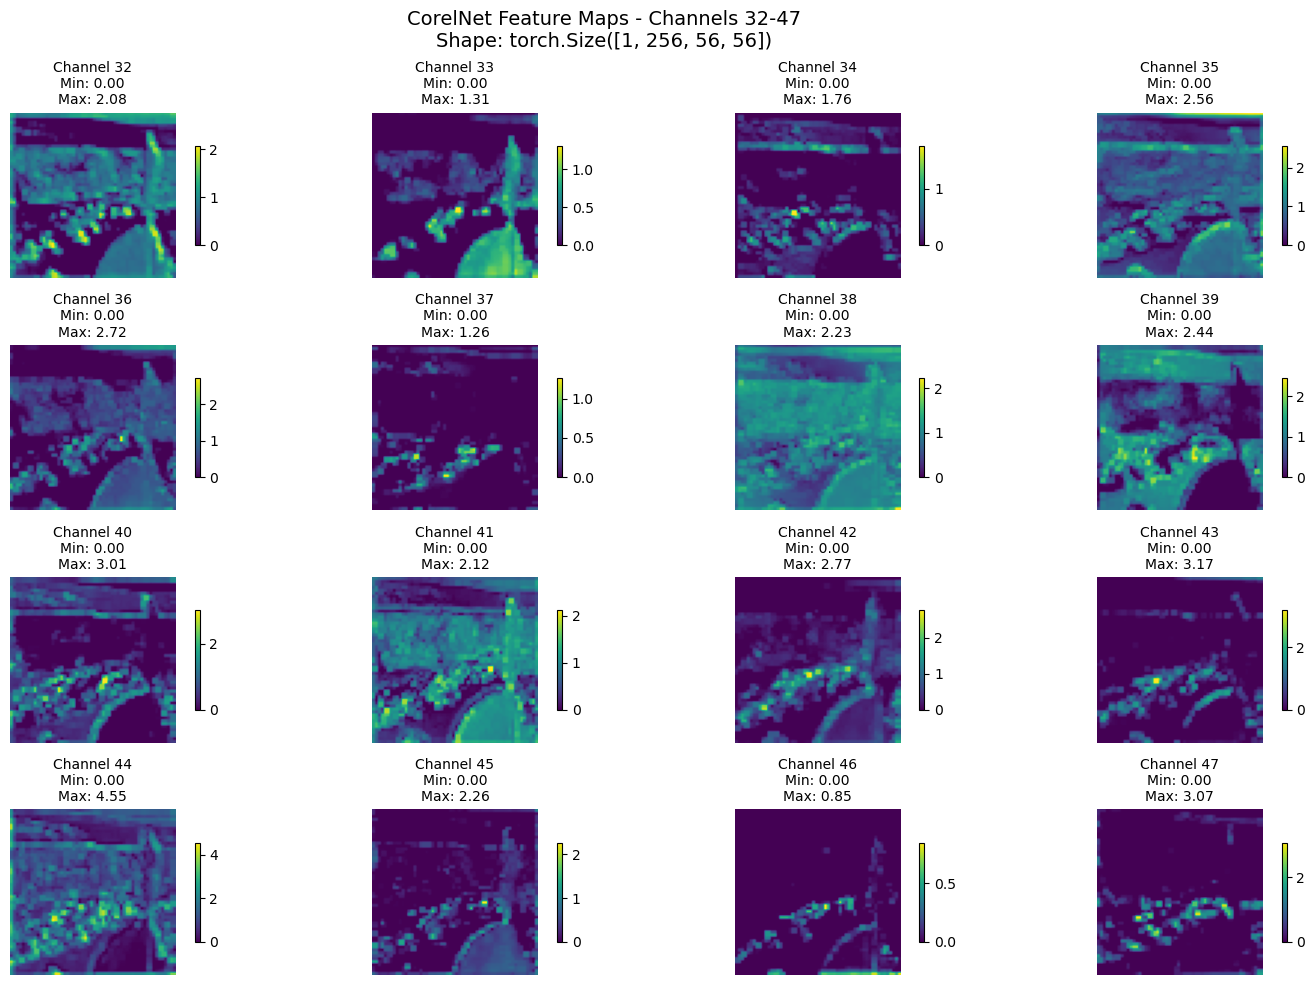

In [21]:
featmap = get_corelnet_feature_map(model,image)
visualize_corelnet_features(featmap, max_channels=16, start_channel=32)

In [22]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Register hooks: it holds the activation map of the target layer during
        # forward operation and the gradients of the kernels in the backward
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_backward_hook(self.save_gradient)
    
    def save_activation(self, module, input, output):
        self.activations = output
    
    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]
    
    def generate_cam(self, input_image, class_idx=None):
        # Forward pass
        model_output = self.model(input_image)
        
        if class_idx is None:
            class_idx = torch.argmax(model_output, dim=1)
        
        # Zero gradients
        self.model.zero_grad()
        
        # Backward pass
        class_score = model_output[:, class_idx]
        class_score.backward()
        
        # Get gradients and activations
        gradients   = self.gradients
        activations = self.activations
        
        # Calculate weights (global average pooling of gradients)
        # If kernel gradients has shape [batch_size, channels, height, width]
        # e.g., gradients.shape = [1, 64, 28, 28]
        # weights = torch.mean(gradients, dim=[2, 3])
        # weights.shape = [1, 64]
        # The height and width dimensions (28, 28) are averaged out: It then
        # averages the gradients of each kernel creating one weight per kernel. In this case, 
        # for a batch of size 1 and 64 kernels, it creates 64 weights
        
        weights = torch.mean(gradients, dim=[2, 3])
        
        # Generate CAM: It is the weighted average of the activation channels using their
        # respective weights
        
        cam = torch.zeros(activations.shape[2:], dtype=torch.float32).to(device)
        for i, w in enumerate(weights[0]):
            cam += w * activations[0, i, :, :]
        
        # Apply ReLU: it might be needed when weights are negatives for some kernels. The above 
        # and this operation is equivalent to a point-wise convolution followed by activation used
        # in decoders to create saliency maps
        cam = F.relu(cam)
        
        # Normalize
        cam = cam - torch.min(cam)
        cam = cam / torch.max(cam)
        
        return cam.detach().cpu().numpy()

def visualize_gradcam(orig_image, cam, alpha=0.4):
    """
    Overlay GradCAM heatmap on original image
    """
    # Resize CAM to match input image size
    cam_resized = cv2.resize(cam, (orig_image.shape[1], orig_image.shape[0]))
    
    # Create heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    
    # Overlay heatmap on original image
    overlayed = heatmap * alpha + orig_image * (1 - alpha)
    overlayed = 255*(overlayed - np.min(overlayed))/(np.max(overlayed)-np.min(overlayed))
    overlayed = overlayed.astype('uint8')
    
    return overlayed, heatmap


In [23]:
# For custom models, you can specify the target layer like this:
def gradcam_custom_model(model, image, target_layer_name):
    """
    Apply GradCAM to a custom model
    """
    # Get target layer by name
    target_layer = dict(model.named_modules())[target_layer_name]
    
    # Initialize GradCAM
    grad_cam = GradCAM(model, target_layer)
       
    # Generate CAM
    cam = grad_cam.generate_cam(image)
    
    return cam


In [24]:
import torch.nn.functional as F
import cv2

conv2d_last_block = model.features[1][0]
for name, module in model.named_modules():
    if module is conv2d_last_block:
        target_layer_name = name
        break    
cam = gradcam_custom_model(model, image, target_layer_name)

/home/afalcao/miniconda3/envs/mo434/lib/python3.12/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


In [25]:
orig_image, target = trainset[100] # it executes getitem
orig_image = orig_image.permute(1,2,0).numpy()
orig_image = 255*(orig_image - np.min(orig_image))/(np.max(orig_image)-np.min(orig_image))
orig_image = orig_image.astype('uint8')
overlayed, heatmap = visualize_gradcam(orig_image, cam, alpha=0.4)

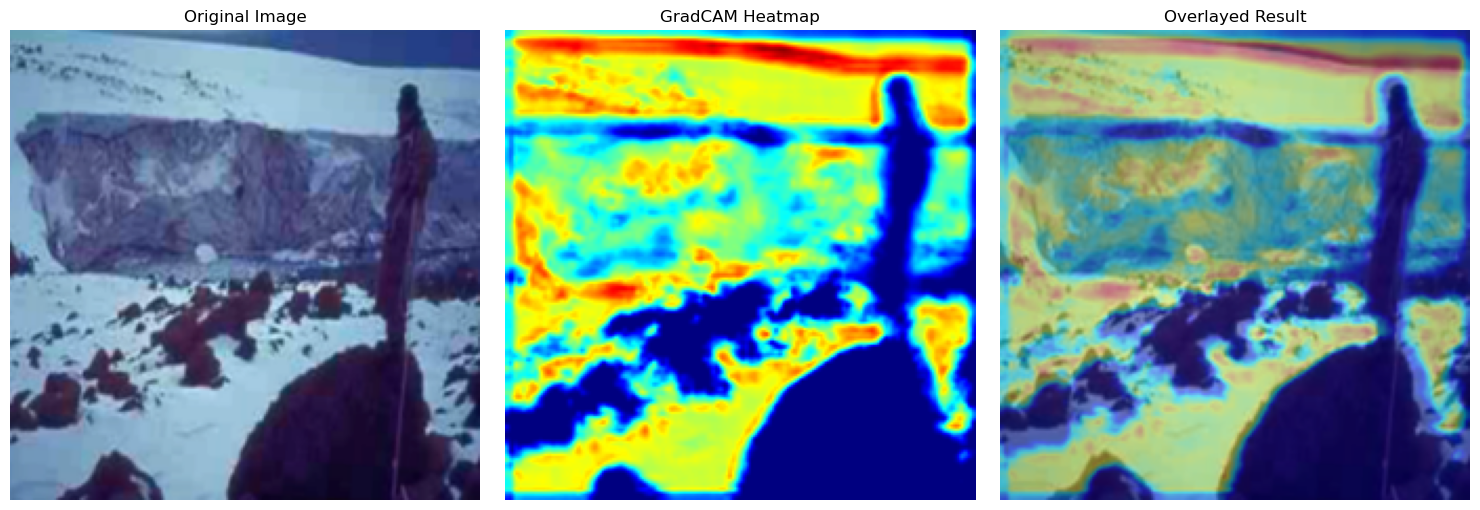

In [26]:
# Plot results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
axes[0].imshow(orig_image)
axes[0].set_title('Original Image')
axes[0].axis('off')
    
axes[1].imshow(heatmap)
axes[1].set_title('GradCAM Heatmap')
axes[1].axis('off')
    
axes[2].imshow(overlayed.astype(np.uint8))
axes[2].set_title('Overlayed Result')
axes[2].axis('off')
    
plt.tight_layout()
plt.show()